<a href="https://colab.research.google.com/github/shinhs0920/Engineering-computing-application/blob/master/seq2seq_medic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##rdkit 설치

In [0]:
import os

# For 현재 라이브러리를 실행합니다
import sys
sys.path.insert(0, "../")

expr_root = os.path.expanduser("~/expr/unsup-seq2seq/")
data_root = os.path.join(expr_root, "data")

if not os.path.exists(data_root):
    os.makedirs(data_root)

seq2seq에 필요한 rdkit를 설치합니다.

In [0]:
def DownloadRDkit():
  !wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
  !chmod +x Miniconda3-latest-Linux-x86_64.sh
  !time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
  !time conda install -q -y -c conda-forge rdkit

In [3]:
DownloadRDkit() # RDkit 다운로드
%matplotlib inline
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2019-12-17 08:27:44--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71785000 (68M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  68.46M   176MB/s    in 0.4s    

2019-12-17 08:27:44 (176 MB/s) - ‘Miniconda3-latest-Linux-x86_64.sh’ saved [71785000/71785000]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.2.0=py37_0
    - ca-certificates==2019.10.16=0
    - certifi==2019.9.11=py37_0
    - cffi==1.13.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h7b6447c_

In [4]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

--2019-12-17 08:28:40--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

PREFIX=/usr/local
Unpacking payload ...
Solving environment: | / - \ | / - \ | / - \ | / done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.2.0=py37_0
    - ca-certificates==2019.10.16=0
    - certifi==2019.9.11=py37_0
    - cffi==1.13.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h7b6447c_0
    - conda==4.7.12=py37_0
    - cryptography==2.8=py37h1ba5d50_0
    - idna==2.8=py37_0
    - libedit==3.1.20181209=hc058e9b_0
  

smiles를 기반으로 분자 autoencoders을 개선하는 방법에 대해 알아 봅니다.

LSTM-RNN 을 사용하고 이 네트워크에 구성된 분자의 SMILES 문자열이 어떻게 형식화되는지에 여러 규칙과 이에 대한 문자를 반복하여 동일한 규칙에 따라 새로운 SMILES를 작성합니다.

좋은 점은 분자 특성의 분포가 훈련 데이터 세트 및 이후 샘플에 대해 동일하다는 것입니다 

그러나 SMILES 생성의 기초가되는 화학적 규칙을 과도하게 맞추지 않고 이러한 문자 기반 생성기 중 하나를 학습하려면 수천 개의 분자가 필요합니다.

따라서 자동 인코더를 만들어서 이용합니다. 기본 아이디어는 입력 (여기서는 SMILES 문자열) 문자열을 잠재 공간에 코딩 한 다음에 공간에서 원래 입력을 다시 작성하는 것입니다. 훈련 후, 자동 인코더는 인코더 및 디코더로 분할 될 수 있습니다.

디코더는 관심있는 분자 주변의 영역을 샘플링하고 유사하지만 동일하지 않은 분자를 생성하는 데 사용될 수 있습니다.

또한 keras-molecules를 사용하여 후속 시각화로 분자를 잠재 공간에 매핑하는 경험에 대해 작성했습니다 . 이 코드는 RNN based incoder와 GRU based decoder를 사용합니다.

In [0]:
import os
import pandas as pd
import numpy as np
from __future__ import print_function
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt
%matplotlib inline

물론 일부 SMILES 문자열을 훈련하고 테스트해야합니다. 이 블로그 게시물의 내용을 좀 더 단순하고 짧게 유지하기 위해 GDB-11 데이터 세트의 원자 8 개가 포함 된 SMILES 파일이 사용됩니다. 원자 및 결합 유형의 하위 집합으로 생성 할 수있는 모든 분자를 포함합니다. 데이터 셋은 http://gdb.unibe.ch/downloads/에서 다운로드 할 수 있습니다 . 트레인 및 테스트 세트로의 임의 분할은 추가 처리 직전에 수행됩니다.

In [6]:
pip install scikit-learn


     |████████████████████████████████| 7.0MB 3.4MB/s 
     |████████████████████████████████| 296kB 57.7MB/s 
     |████████████████████████████████| 26.1MB 1.2MB/s 


In [7]:
smifile = "gdb11_size08.smi"
data = pd.read_csv(smifile, delimiter = "\t", names = ["smiles","No","Int"])
from sklearn.model_selection import train_test_split
smiles_train, smiles_test = train_test_split(data["smiles"], random_state=42)

print (smiles_train.shape)
print (smiles_test.shape)

(50029,)
(16677,)


SMILES는 one-hot 인코딩 배열로 벡터화해야합니다. 이를 위해 문자 세트는 SMILES 문자열 (트레인 및 테스트)에있는 모든 문자로 구성됩니다. 또한 일부 시작 및 중지 문자가 추가되어 디코더를 시작하고 SMILES 생성이 중지되었을 때 신호를 보내는 데 사용됩니다. 정지 문자는 또한 패딩으로 작동하여 모든 벡터의 동일한 길이를 얻으므로 네트워크를 배치 모드로 학습 할 수 있습니다. 문자 집합은 인덱스와 문자 사이를 앞뒤로 번역 할 두 사전을 정의하는 데 사용됩니다. RNN이 배치 모드에서 학습되고 최대 발생 + 일부 추가로 설정되므로 SMILES 문자열의 최대 길이가 필요합니다.

In [8]:
charset = set("".join(list(data.smiles))+"!E")
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))
embed = max([len(smile) for smile in data.smiles]) + 5
print (str(charset))
print(len(charset), embed)

{'[', 'N', '#', 'O', '(', 'n', '4', ']', 'C', '-', 'H', ')', '1', '!', 'c', 'E', '+', '=', 'o', 'F', '3', '2'}
22 28


그 후 문자 세트와 사전은 Numpy 배열에서 필요한 비트를 설정하는 데 사용됩니다. 결과는 각 분자 SMILES 스트링의 "피아노 롤"이됩니다. X 데이터는!로 시작하지만 출력 Y는 한 문자 씩 오프셋되고 실제 SMILES의 첫 번째 문자로 시작합니다.

N#CC#CC1COC1


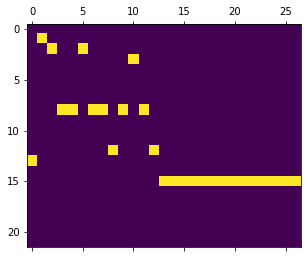

In [9]:
def vectorize(smiles):
        one_hot =  np.zeros((smiles.shape[0], embed , len(charset)),dtype=np.int8)
        for i,smile in enumerate(smiles):
            #encode the startchar
            one_hot[i,0,char_to_int["!"]] = 1
            #encode the rest of the chars
            for j,c in enumerate(smile):
                one_hot[i,j+1,char_to_int[c]] = 1
            #Encode endchar
            one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
        #Return two, one for input and the other for output
        return one_hot[:,0:-1,:], one_hot[:,1:,:]
X_train, Y_train = vectorize(smiles_train.values)
X_test,Y_test = vectorize(smiles_test.values)
print (smiles_train.iloc[0])
plt.matshow(X_train[0].T)
#print X_train.shape

In [10]:
"".join([int_to_char[idx] for idx in np.argmax(X_train[0,:,:], axis=1)])

'!N#CC#CC1COC1EEEEEEEEEEEEEE'

벡터화 된 데이터가 준비되면 자동 인코더를 구축 할 차례입니다. 먼저 일부 Keras 객체를 가져오고 벡터화 데이터에서 입력 및 출력 치수를 계산합니다. 또한 디코더 및 인코더에 사용할 LSTM 셀의 수가 지정되고 잠재 치수가 지정됩니다.

In [11]:
#Import Keras objects
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Concatenate
from keras import regularizers
input_shape = X_train.shape[1:]
output_dim = Y_train.shape[-1]
latent_dim = 64
lstm_dim = 64

Using TensorFlow backend.


이는 TensorFlow 백엔드를 사용한다는 뜻입니다.

# 긴 단기 메모리 셀(LSTM)

그것은 옥시 모론처럼 들릴지 모르지만, 장기적인 단기 기억 세포재귀 신경 네트워크를 통해 더 긴 반복을 위해 내부 상태를 유지하도록 설계된 특수 종류의 신경 네트워크 장치입니다. 이들은 입력, 출력 및 잊어 버림 게이트로 설계되어 셀 내부 상태 C로 수행 할 작업을 제어합니다. 상태 H는 반복 반복 사이의 복사본으로 전달되며 내부 상태 C에서 수행 할 작업을 결정하는 데 도움이됩니다. 다음 반복. 게이팅 메커니즘은 네트워크가 입력을 닫아 새로운 상태 나 입력이 열릴 때까지 게이트를 잊어 내부 상태를 쉽게 유지할 수 있도록합니다. 표준 반복 단위의 드롭 인 대체품으로 사용되며 일반적으로 장기 상호 작용 인식과 관련하여 RNN의 성능을 향상시킵니다. 운좋게도 그들은 이미 Keras에서 구현되었습니다

또한 인기있는

모델은 전체적으로 다소 단순합니다. 64 LSTM 셀의 단일 레이어는 입력 SMILES 문자열을 읽는 데 사용됩니다. 레이어의 출력은 무시되지만 최종 내부 C 및 H 상태는 연결되고 병목 레이어 "목"으로 다시 결합됩니다. 이것은 인코더로 구성됩니다.
Keras의 기능적 API가 사용되므로 나중에 다양한 레이어를 인코더 및 디코더 모델로 쉽게 재구성 할 수 있습니다.

In [12]:
unroll = False
encoder_inputs = Input(shape=input_shape)
encoder = LSTM(lstm_dim, return_state=True,
                unroll=unroll)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
states = Concatenate(axis=-1)([state_h, state_c])
neck = Dense(latent_dim, activation="relu")
neck_outputs = neck(states)

그런 다음 neck_output 텐서는 디코더 LSTM 레이어에 설정되어야하는 상태를 디코딩하기 위해 두 개의 서로 다른 Dense 레이어를 통과합니다. 인코더에서 디코더로의 내부 상태의 이러한 재결합은 LSTM 계층 자체에 의해 인코딩 된 것과 다른 크기의 잠재 공간을 사용할 수있게한다. LSTM 레이어는 입력을 다시 한 번 수신하고 시퀀스의 다음 문자를 예측하는 작업을 수행합니다. 따라서 분자와 문자 "!"의 잠복 표현에서 첫 번째 원자를 나타내는 다음 문자가 무엇인지 출력해야합니다 (예 : "C", "N"등). 따라서 Y 벡터가 X에서 오프셋됩니다. "!"문자가있는 벡터 이 훈련 방법은 한 번의 재발 단계의 결과가 다음 단계의 입력으로 사용되는 접근법과 달리 교사 시행이라고합니다. 네트워크가 시퀀스 시작에서 실수를 할 수는 있지만 시퀀스의 후반부에 대한 교육에는 영향을 미치지 않습니다. 이를 통해 디코더는 내부 상태를 공급 한 다음 전체 시퀀스를 구성 할 수 있는지 확인하는 것보다 훨씬 효율적으로 디코더를 학습시킵니다. 각 단계에서 출력되는 LSTM 세포는 올바른 특성을 예측하기 위해 각 뉴런 작업과 함께 밀도가 높은 네트워크에 배치됩니다.
훈련을위한 최종 모델은 입력 레이어 객체와 출력 레이어에서 만들어집니다.

In [16]:
decode_h = Dense(lstm_dim, activation="relu")
decode_c = Dense(lstm_dim, activation="relu")
state_h_decoded =  decode_h(neck_outputs)
state_c_decoded =  decode_c(neck_outputs)
encoder_states = [state_h_decoded, state_c_decoded]
decoder_inputs = Input(shape=input_shape)
decoder_lstm = LSTM(lstm_dim,
                    return_sequences=True,
                    unroll=unroll
                   )
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(output_dim, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
#Define the model, that inputs the training vector for two places, and predicts one character ahead of the input
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
print (model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 27, 22)       0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 64), (None,  22272       input_1[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 128)          0           lstm_1[0][1]                     
                                                                 lstm_1[0][2]                     
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           8256        concatenate_1[0][0]        

훈련 고원에 도달하면 기록을 기록하고 학습 속도를 줄이기 위해 일부 Keras 콜백을 준비한 후 모델은 최적화 및 손실 기능으로 컴파일되어 훈련을 시작할 수 있습니다. X_train이 모델에 두 번 공급되어 모델의 두 곳에서 입력을받는 방법에 유의하십시오.

In [17]:
from keras.callbacks import History, ReduceLROnPlateau
h = History()
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=0.000001, verbose=1, epsilon=1e-5)

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [18]:
from keras.optimizers import RMSprop, Adam
opt=Adam(lr=0.005) #Default 0.001
model.compile(optimizer=opt, loss='categorical_crossentropy')


In [24]:
model.fit([X_train,X_train],Y_train,
                    epochs=100,
                    batch_size=256,
                    shuffle=True,
                    callbacks=[h, rlr],
                    validation_data=[[X_test,X_test],Y_test ])


Train on 50029 samples, validate on 16677 samples
Epoch 1/100
50029/50029 [==============================] - 16s 312us/step - loss: 0.0452 - val_loss: 0.0610
Epoch 2/100
50029/50029 [==============================] - 15s 309us/step - loss: 0.0527 - val_loss: 0.0659
Epoch 3/100
50029/50029 [==============================] - 16s 311us/step - loss: 0.0377 - val_loss: 0.0310
Epoch 4/100
50029/50029 [==============================] - 16s 315us/step - loss: 0.0369 - val_loss: 0.0762
Epoch 5/100
50029/50029 [==============================] - 16s 314us/step - loss: 0.0336 - val_loss: 0.0278
Epoch 6/100
50029/50029 [==============================] - 16s 313us/step - loss: 0.0277 - val_loss: 0.0314
Epoch 7/100
50029/50029 [==============================] - 16s 311us/step - loss: 0.1058 - val_loss: 0.1001
Epoch 8/100
50029/50029 [==============================] - 16s 313us/step - loss: 0.0439 - val_loss: 0.0265
Epoch 9/100
50029/50029 [==============================] - 16s 314us/step - loss: 0.02

훈련과정은 기록된 데이터들과 플롯되어 아래의 그래프를 나타냅니다.

손실 및 유효성 검사 손실에는 약간의 급증이 있지만 결국 손실 및 유효성 검사 손실 은 점점 떨어집니다. 

로그 스케일은 손실과 유효성 검증 손실 사이의 증가하는 차이가 실제보다 크게 나타납니다.

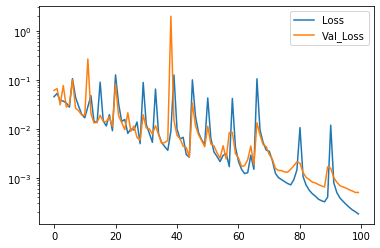

In [25]:
plt.plot(h.history["loss"], label="Loss")
plt.plot(h.history["val_loss"], label="Val_Loss")
plt.yscale("log")
plt.legend()

훈련 된 데이터를 새로운 모델로 재구성 하기 전에 모델에 대한 빠른 테스트를 통해 테스트 세트에서도 재구성 정확도가 우수함을 알 수 있습니다.

 아래 코드는 아무것도 출력하지 않으므로 테스트 세트에서 100 개의 테스트 된 SMILES을 그대로 재사용합니다.

In [0]:
for i in range(100):
    v = model.predict([X_test[i:i+1], X_test[i:i+1]]) #Can't be done as output not necessarely 1
    idxs = np.argmax(v, axis=2)
    pred=  "".join([int_to_char[h] for h in idxs[0]])[:-1]
    idxs2 = np.argmax(X_test[i:i+1], axis=2)
    true =  "".join([int_to_char[k] for k in idxs2[0]])[1:]
    if true != pred:
        print (true, pred)

이제 훈련 된 자동 인코더의 일부를 사용하여 다양한 인코더 및 디코더 모델을 작성합니다. 입력 레이어에서 다른 모델 내부의 출력 레이어로 새 모델을 작성하는 것은 매우 간단합니다. 모델이 빌드 될 때 정의 된 입력 레이어는 재사용되고 neck_output은 출력으로 재사용됩니다. 이 모델은 벡터화 된 미소를 취하여 잠재 공간으로 인코딩합니다.

In [0]:
smiles_to_latent_model = Model(encoder_inputs, neck_outputs)


In [0]:
smiles_to_latent_model.save("Blog_simple_smi2lat.h5")


다음에 필요한 모델은 잠재 공간을 디코더 LSTM 셀에서 설정해야하는 상태로 디코딩 할 수있는 모델입니다. 잠재 공간과 일치하는 새로운 입력이 정의되었지만 이전의 레이어를 재사용하여 h 및 c 상태를 얻을 수 있습니다. 그렇게하면 가중치가 훈련 된 모델에서 상속됩니다.

In [0]:
latent_input = Input(shape=(latent_dim,))
#reuse_layers
state_h_decoded_2 =  decode_h(latent_input)
state_c_decoded_2 =  decode_c(latent_input)
latent_to_states_model = Model(latent_input, [state_h_decoded_2, state_c_decoded_2])
latent_to_states_model.save("Blog_simple_lat2state.h5")


디코더 모델에는 약간 더 많은 작업이 필요합니다. 배치 모드에서 학습되었지만 한 번에 한 문자를 예측하는 상태 저장 모드에서 사용됩니다. 따라서 새로운 batch_shape와 LSTM 레이어가 stateful로 설정된 경우를 제외하고 레이어는 이전과 같이 정확하게 정의됩니다.

In [0]:
#Last one is special, we need to change it to stateful, and change the input shape
inf_decoder_inputs = Input(batch_shape=(1, 1, input_shape[1]))
inf_decoder_lstm = LSTM(lstm_dim,
                    return_sequences=True,
                    unroll=unroll,
                    stateful=True
                   )
inf_decoder_outputs = inf_decoder_lstm(inf_decoder_inputs)
inf_decoder_dense = Dense(output_dim, activation='softmax')
inf_decoder_outputs = inf_decoder_dense(inf_decoder_outputs)
sample_model = Model(inf_decoder_inputs, inf_decoder_outputs)

디코더 모델을 정의한 후 학습 된 자동 인코더 모델에서 해당 가중치가 전송됩니다

In [0]:
#Transfer Weights
for i in range(1,3):
    sample_model.layers[i].set_weights(model.layers[i+6].get_weights())
sample_model.save("Blog_simple_samplemodel.h5")

In [33]:
sample_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (1, 1, 22)                0         
_________________________________________________________________
lstm_3 (LSTM)                (1, 1, 64)                22272     
_________________________________________________________________
dense_5 (Dense)              (1, 1, 22)                1430      
Total params: 23,702
Trainable params: 23,702
Non-trainable params: 0
_________________________________________________________________


#Using the latent space as a fingerprint


잠재 모델에 대한 스마일은 잠재 공간과 같은 SMILES를 지문으로 인코딩하는 데 사용할 수 있습니다.

In [0]:
x_latent = smiles_to_latent_model.predict(X_test)

fingerprint의 유용한 기능은 유사한 분자가 유사한 fingerprint를 생성하는 것입니다. 유사한 분자가 latent space에서 유사한 벡터를 생성하는지 확인하기 위해 유사한 분자에 대한 간단한 검색을 수행 할 수 있습니다.

 여기서 latent vector 간의 절대 차이는 metric of similarity로 사용됩니다. 
 
 이 테스트는 유사한 분자가 유사하지 않은 잠재 벡터를 얻을 수 있다는 것을 배제하지는 않지만 바로 근처에 대한 빠른 테스트입니다.

[    5  1243 14589   744 15039 15472  5251  3991  2449  5247]
45051    COCc1cocn1
45007    COCc1ccoc1
44719    COCc1ccno1
45025    CCOc1cnoc1
45069    COCc1ncon1
45061    COCc1conn1
44751    COCc1ncno1
44727    COCc1cnno1
Name: smiles, dtype: object


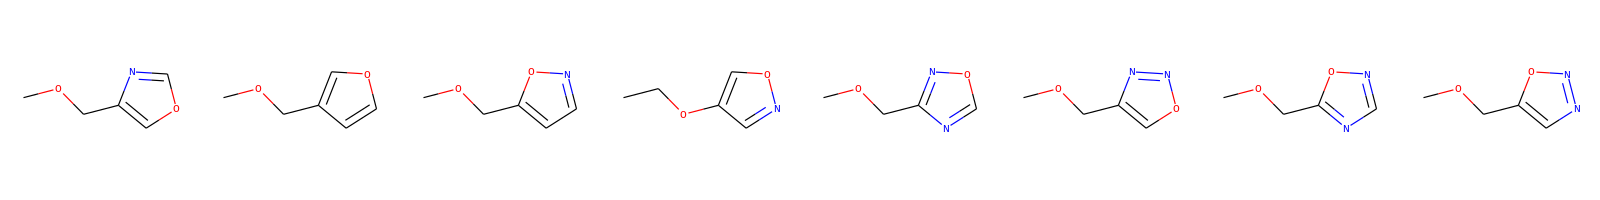

In [36]:
molno = 5
latent_mol = smiles_to_latent_model.predict(X_test[molno:molno+1])
sorti = np.argsort(np.sum(np.abs(x_latent - latent_mol), axis=1))
print (sorti[0:10])
print (smiles_test.iloc[sorti[0:8]])
Draw.MolsToImage(smiles_test.iloc[sorti[0:8]].apply(Chem.MolFromSmiles))


첫 번째는 쿼리 분자입니다. 그것들은 비슷해 보이지만 분자 유사성에 대한 우리의 이해를 따르기보다는 SMILES 줄이 매우 유사하기 때문일 수 있습니다. 잠재 공간에서 가장 다른 분자가 무엇인지 살펴 보겠습니다.

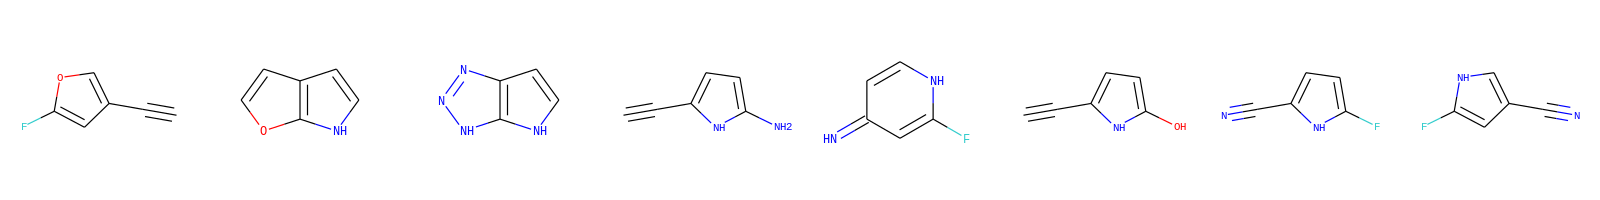

In [37]:
Draw.MolsToImage(smiles_test.iloc[sorti[-8:]].apply(Chem.MolFromSmiles))


# Chemical properties in the latent space


화학적 특성의 대리자로서, 계산 된 LogP 및 MR이 잠재 공간의 PCA 감소에 어떻게 매핑되는지 확인하십시오

In [0]:
logp = smiles_test.apply(Chem.MolFromSmiles).apply(Descriptors.MolLogP)

[0.23995464 0.18968782] 0.42964244


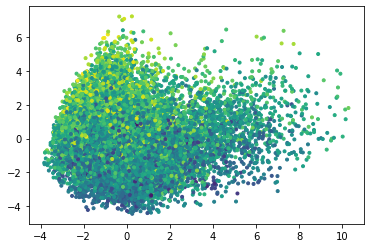

In [39]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
red = pca.fit_transform(x_latent)
plt.figure()
plt.scatter(red[:,0], red[:,1],marker='.', c= logp)
print(pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_))


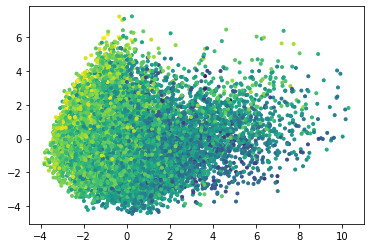

In [40]:
molwt = smiles_test.apply(Chem.MolFromSmiles).apply(Descriptors.MolMR)
plt.figure()
plt.scatter(red[:,0], red[:,1],marker='.', c= molwt)


예측 된 분자 특성의 분포가있는 것 같습니다.

# Modeling properties from the latent space


지문이 QSAR 모델의 기초로 잘 작동하는지 확인하는 것도 흥미로울 수 있습니다. QSAR 모델링의 목표 값에 대한 프록시로서 예측 된 LogP 모델이 작성됩니다. 모델링 된 속성을 사용하여 모델을 작성하는 것은 데모 목적으로 만 수행됩니다.

In [0]:
#Model LogP?
x_train_latent = smiles_to_latent_model.predict(X_train)
logp_train = smiles_train.apply(Chem.MolFromSmiles).apply(Descriptors.MolLogP)


In [0]:
from keras.models import Sequential
logp_model = Sequential()
logp_model.add(Dense(128, input_shape=(latent_dim,), activation="relu"))
logp_model.add(Dense(128, activation="relu"))
logp_model.add(Dense(1))
logp_model.compile(optimizer="adam", loss="mse")

In [43]:
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=0.000001, verbose=1, epsilon=1e-5)
logp_model.fit(x_train_latent, logp_train, batch_size=128, epochs=200, callbacks = [rlr])

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Epoch 1/200
50029/50029 [==============================] - 1s 29us/step - loss: 0.4099
Epoch 2/200
 7296/50029 [===>..........................] - ETA: 0s - loss: 0.3219

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1379: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


50029/50029 [==============================] - 1s 22us/step - loss: 0.3056
Epoch 3/200
50029/50029 [==============================] - 1s 23us/step - loss: 0.2656
Epoch 4/200
50029/50029 [==============================] - 1s 21us/step - loss: 0.2490
Epoch 5/200
50029/50029 [==============================] - 1s 21us/step - loss: 0.2278
Epoch 6/200
50029/50029 [==============================] - 1s 21us/step - loss: 0.2180
Epoch 7/200
50029/50029 [==============================] - 1s 20us/step - loss: 0.2113
Epoch 8/200
50029/50029 [==============================] - 1s 23us/step - loss: 0.2022
Epoch 9/200
50029/50029 [==============================] - 1s 21us/step - loss: 0.1942
Epoch 10/200
50029/50029 [==============================] - 1s 21us/step - loss: 0.1886
Epoch 11/200
50029/50029 [==============================] - 1s 21us/step - loss: 0.1831
Epoch 12/200
50029/50029 [==============================] - 1s 21us/step - loss: 0.1772
Epoch 13/200
50029/50029 [==========================

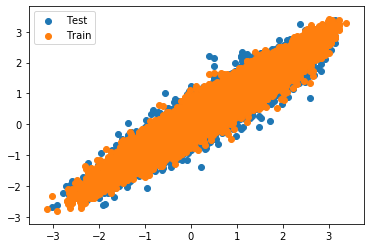

In [44]:
logp_pred_train = logp_model.predict(x_train_latent)
logp_pred_test = logp_model.predict(x_latent)
plt.scatter(logp, logp_pred_test, label="Test")
plt.scatter(logp_train, logp_pred_train, label="Train")
plt.legend()

모델링 된 property를  모델링 할 때 훨씬 더 잘 맞을 것으로 예상됩니다.

# From latent space to SMILES


latent space를 샘플링하려면 두 단계가 필요합니다. 

먼저 latent_to_states_model을 사용하여 state h & state c를 계산 한 다음 디코더 LSTM 네트워크의 초기 상태를 설정합니다.

LSTM 네트워크에는 입력 문자 벡터가 입력되고 끝 문자 "E"가 나타날 때까지 다음 문자를 반복적으로 샘플링합니다.

In [0]:
def latent_to_smiles(latent):
    #decode states and set Reset the LSTM cells with them
    states = latent_to_states_model.predict(latent)
    sample_model.layers[1].reset_states(states=[states[0],states[1]])
    #Prepare the input char
    startidx = char_to_int["!"]
    samplevec = np.zeros((1,1,22))
    samplevec[0,0,startidx] = 1
    smiles = ""
    #Loop and predict next char
    for i in range(28):
        o = sample_model.predict(samplevec)
        sampleidx = np.argmax(o)
        samplechar = int_to_char[sampleidx]
        if samplechar != "E":
            smiles = smiles + int_to_char[sampleidx]
            samplevec = np.zeros((1,1,22))
            samplevec[0,0,sampleidx] = 1
        else:
            break
    return smiles

In [47]:
smiles = latent_to_smiles(x_latent[0:1])
print (smiles)
print (smiles_test.iloc[0])

NCCC1OC=NO1
NCCC1OC=NO1


테스트 세트를 샘플링 할 때 SMILES의 비율이 얼마나 큰지 아는 것이 적절할 수 있습니까?

In [49]:
wrong = 0
for i in range(1000):
    smiles = latent_to_smiles(x_latent[i:i+1])
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        pass
    else:
        print (smiles)
        wrong = wrong + 1
print ("%0.1F percent wrongly formatted smiles"%(wrong/float(1000)*100))


Cc1[nH]ccc1=NO
0.1 percent wrongly formatted smiles


즉  smile 형태에서 0.1% 오차가 있습니다.

이것은 실제로 아주 좋습니다. 또 다른 흥미로운 점은 잠복 공간에서 분자가 "보간"될 수 있는지 확인하는 것입니다.

NCCC1=OCOC1
NCC1CNC2ON1
CN1CCCON=C12
CN1CCCON=C12


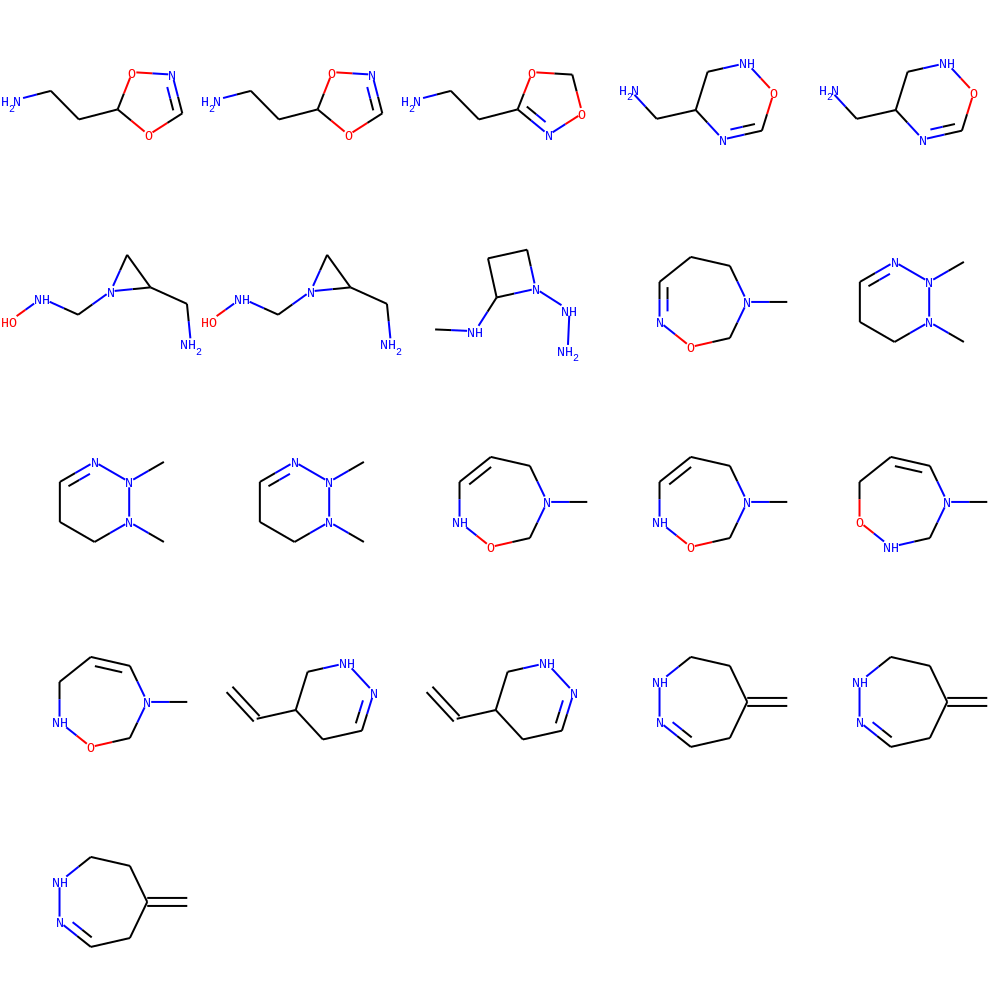

In [51]:
#Interpolation test in latent_space
i = 0
j= 2
latent1 = x_latent[j:j+1]
latent0 = x_latent[i:i+1]
mols1 = []
ratios = np.linspace(0,1,25)
for r in ratios:
    #print r
    rlatent = (1.0-r)*latent0 + r*latent1
    smiles  = latent_to_smiles(rlatent)
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        mols1.append(mol)
    else:
        print (smiles)
Draw.MolsToGridImage(mols1, molsPerRow=5)

25 개 분자 중 2 개를 파싱 할 수 없기 때문에 잘못된 샘플링이 더 높은 것 같습니다. 보간은 또한 잠복 공간의 약간 다른 영역에 대해 동일한 분자가 어떻게 생성되는지를 보여줍니다. 이것은 분자가 불연속적이고 잠복 공간이 연속적이라는 것을 반영하며, 우리가 두 분자 사이의 경계에있을 때 실패 할 가능성이 높습니다.
검사해야 할 또 다른 흥미로운 특성은 기존 분자 벡터에 약간의 무작위성을 추가함으로써 리드 분자와 다소 유사한 신규 분자가있을 수 있는지입니다.

NCCOC12OCN1
OCCC1C=OCO1
NCCC1CON=1O
NCCOC1CNN
NCC(=O)CON1N
NCOC1CO=CN1
NCCC1COC2=N1
NCOCC1ON=O1
COCCC1=ONN1
NCCCO1C2CO1O
NCCOC1=OOCO1
CNCC(O1=N)CN1
NCCOC=N1NN
NCCC1O=COC1
COCCO1CON1
NNC1CCO=N1CF


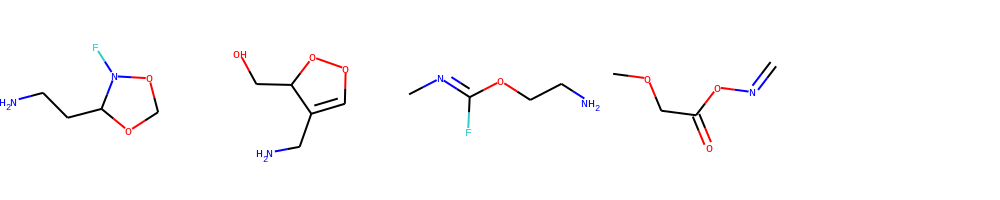

In [58]:
#Sample around the latent wector
latent = x_latent[0:1]
scale = 0.40
mols = []
for i in range(20):
    latent_r = latent + scale*(np.random.randn(latent.shape[1])) #TODO, try with
    smiles = latent_to_smiles(latent_r)
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        mols.append(mol)
    else:
        print (smiles)
        
Draw.MolsToGridImage(mols, molsPerRow=5)

여기서 우리는 실제로 많은 잘못된 SMILES가 생성되는 것을 볼 수 있지만 그럼에도 불구하고 잠재 벡터를 인코딩하는 데 사용 된 것과 다소 유사 할 수있는 일부 분자를 볼 수 있습니다.

 (위 보간에서 첫 번째 분자와 비교). 스케일링을 조정하면 창의성을 튜닝 할 수 있습니다.


NCCOC=C1NN
NCCCC1OC=O1
NCCC1CO=CO1
NCCO1C2CON1
NCCCO1C=CO1
NCCC1CON=O1
NCCCOC1=CO
NCCCO1C=CO1
NCCC1CON=N1F


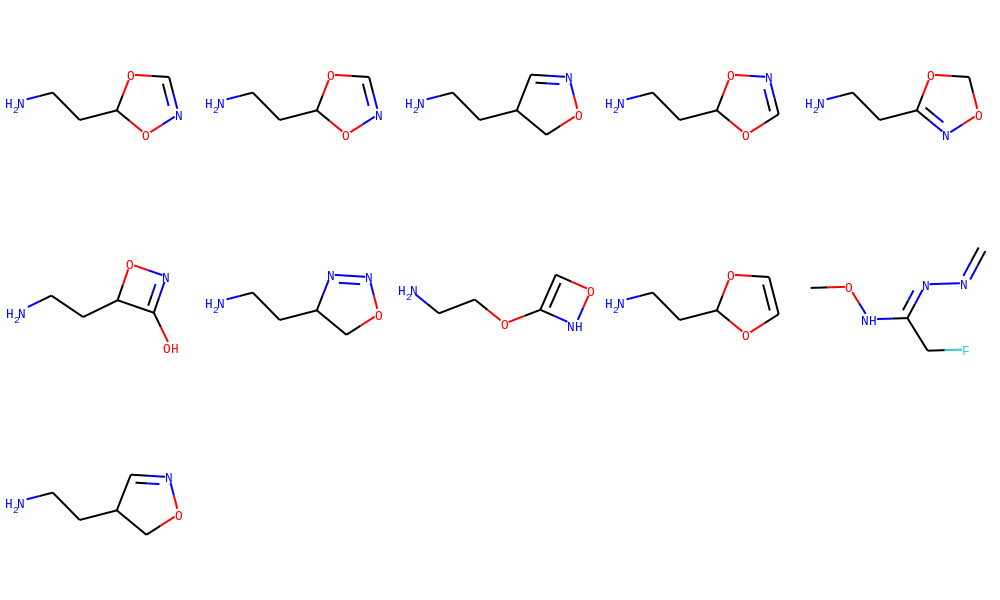

In [64]:
#Sample around the latent wector
latent = x_latent[0:1]
scale = 0.20
mols = []
for i in range(20):
    latent_r = latent + scale*(np.random.randn(latent.shape[1])) #TODO, try with
    smiles = latent_to_smiles(latent_r)
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        mols.append(mol)
    else:
        print (smiles)
        
Draw.MolsToGridImage(mols, molsPerRow=5)

scale을 0.2로 했더니 위와 비슷함을 알 수 있습니다.

#정리

이 블로그 포스트에서는 SMILES 분자 분자의 LSTM 기반 자동 인코더를 만드는 방법과 교사 시행으로 효율적으로 훈련하는 방법을 보여주었습니다. 잠재 공간은 SMILES의 구조를 반영 할 수 있지만 그럼에도 불구하고 다양한 화학 포맷 관련 작업에 유용하게 보입니다. 분자들 사이의 도메인 경계를 정하거나 랜덤 노이즈를 추가 할 때 SMILES 재구성 정확도가 떨어지는 것처럼 보입니다. 따라서, 잠재 공간은 분자의 불연속 특성을 반영하여 완전히 연속적이지 않을 수있다. 처음에는 지능을 정의하는 방법을 잘 모르기 때문에이 블로그 게시물에서 AI를 언급하지 않았지만 SMILES 문자열의 화학적 규칙을 수행하는 가중치와 계산으로 어떻게 찾을 수 있는지는 매력적입니다. LSTM 셀의 신경망은 나중에 새로운 SMILES 스트링을 만드는 데 사용됩니다.

In [0]:
# Train/test data iter.

train_data_path = "/smile/nfs/projects/nih_drug/data/pm2/pm2.smi"
test_data_path = "/smile/nfs/projects/nih_drug/data/logp/logp.smi"

def smi_data_iter(smi_path):
    """Yield logp SMILE representation."""
    with open(smi_path) as fobj:
        for line in fobj:
            if not len(line.strip()):
                continue
            _smile = line.strip().split()[0]
            yield _smile

In [54]:
def build_data_tmp(data_iter, data_path):
    """Build temp data file inside the data_directory. This is required for tensorflow function."""
    with open(data_path, "w+") as fobj:
        for _smile in data_iter:
            fobj.write("%s\n" % _smile)
            
train_smile_path = os.path.join(data_root, "pm2.smiles")
test_smile_path = os.path.join(data_root, "logp.smiles")
 
build_data_tmp(smi_data_iter(train_data_path), train_smile_path)
build_data_tmp(smi_data_iter(test_data_path), test_smile_path)

FileNotFoundError: ignored

In [55]:
from __future__ import print_function

import smile as sm
from smile import flags
from unsupervised.data import build_vocab, translate_tokens


flags.DEFINE_string(
    "smi_path", "/smile/nfs/projects/nih_drug/data/logp/logp.smi", "smi data path.")
flags.DEFINE_string(
    "tmp_path", "", "Temporary data path. If none, a named temporary file will be used.")
flags.DEFINE_string(
    "vocab_path", "", "Vocabulary data_path.")
flags.DEFINE_string(
    "out_path", "", "Output token path.")
flags.DEFINE_bool(
    "build_vocab", False, "Trigger the action: False for translating only. "
    "If true, the script will build vocabulary and then translating.")

FLAGS = flags.FLAGS

def main(_):
    """Entry function for this script."""
    if FLAGS.build_vocab:
        build_vocab(FLAGS.smi_path, FLAGS.vocab_path, FLAGS.out_path, FLAGS.tmp_path)
    else:
        translate_tokens(FLAGS.smi_path, FLAGS.vocab_path, FLAGS.out_path, FLAGS.tmp_path)

if __name__ == "__main__":
    sm.app.run()

ModuleNotFoundError: ignored

In [0]:
from unsupervised.utils import true_smile_tokenizer, data_to_token_ids

train_token_path = os.path.join(data_root, "pm2.tokens")
test_token_path = os.path.join(data_root, "logp.tokens")

data_to_token_ids(train_smile_path, train_token_path, vocab_path, true_smile_tokenizer)
data_to_token_ids(test_smile_path, test_token_path, vocab_path, true_smile_tokenizer)

In [0]:
# Build vocabulary from train_data


from unsupervised.utils import true_smile_tokenizer, get_vocabulary

vocab_path = os.path.join(data_root, "pm2.vocab")

get_vocabulary(train_smile_path, vocab_path, tokenizer=true_smile_tokenizer)

In [56]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import json
import os
import random

import numpy as np
import tensorflow as tf

from .base_hparams import build_base_hparams
from .utils import (initialize_vocabulary, sentence_to_token_ids, smile_tokenizer, EOS_ID, PAD_ID,
                    GO_ID)

class Seq2SeqModel(object): # pylint: disable=too-many-instance-attributes
    """Customized seq2seq model for fingerprint method."""
    MODEL_PARAMETER_FIELDS = [
        # Feedforward parameters.
        "source_vocab_size", "target_vocab_size", "buckets", "size", "num_layers", "dropout_rate",
        # Training parameters.
        "max_gradient_norm", "batch_size", "learning_rate", "learning_rate_decay_factor"
    ]

    def __init__(self, # pylint: disable=too-many-locals, too-many-arguments, super-init-not-called
                 hparams,
                 forward_only=False,
                 use_lstm=False,
                 num_samples=512,
                 dtype=tf.float32):
        """Create the model.
        Args:
            source_vocab_size: size of the source vocabulary.
            target_vocab_size: size of the target vocabulary.
            buckets: a list of pairs (I, O), where I specifies maximum input length
                that will be processed in that bucket, and O specifies maximum output
                length. Training instances that have inputs longer than I or outputs
                longer than O will be pushed to the next bucket and padded accordingly.
                We assume that the list is sorted, e.g., [(2, 4), (8, 16)].
            size: number of units in each layer of the model.
            num_layers: number of layers in the model.
            max_gradient_norm: gradients will be clipped to maximally this norm.
            batch_size: the size of the batches used during training;
                the model construction is independent of batch_size, so it can be
                changed after initialization if this is convenient, e.g., for decoding.
            learning_rate: learning rate to start with.
            learning_rate_decay_factor: decay learning rate by this much when needed.
            use_lstm: if true, we use LSTM cells instead of GRU cells.
            num_samples: number of samples for sampled softmax.
            forward_only: if set, we do not construct the backward pass in the model.
            dtype: the data type to use to store internal variables.
        """
        self.source_vocab_size = hparams.source_vocab_size
        self.target_vocab_size = hparams.target_vocab_size
        self.buckets = hparams.buckets
        self.size = hparams.size
        self.num_layers = hparams.num_layers
        self.max_gradient_norm = hparams.max_gradient_norm
        self.batch_size = hparams.batch_size
        self.learning_rate = hparams.learning_rate
        self.learning_rate_decay_factor = hparams.learning_rate_decay_factor
        self.learning_rate_op = tf.Variable(
            float(self.learning_rate), trainable=False, dtype=dtype)
        self.learning_rate_decay_op = self.learning_rate_op.assign(
            self.learning_rate_op * hparams.learning_rate_decay_factor)
        self.dropout_rate = hparams.dropout_rate
        self.global_step = tf.Variable(0, trainable=False)

        size = hparams.size
        buckets = hparams.buckets
        dropout_rate = hparams.dropout_rate
        num_layers = hparams.num_layers

        # If we use sampled softmax, we need an output projection.
        output_projection = None
        softmax_loss_function = None
        # Sampled softmax only makes sense if we sample less than vocabulary size.
        if num_samples > 0 and num_samples < self.target_vocab_size:
            w_t = tf.get_variable("proj_w", [self.target_vocab_size, hparams.size], dtype=dtype)
            w = tf.transpose(w_t)
            b = tf.get_variable("proj_b", [self.target_vocab_size], dtype=dtype)
            output_projection = (w, b)

            def sampled_loss(labels, logits):
                """Sampleed loss function."""
                labels = tf.reshape(labels, [-1, 1])
                # We need to compute the sampled_softmax_loss using 32bit floats to
                # avoid numerical instabilities.
                local_w_t = tf.cast(w_t, tf.float32)
                local_b = tf.cast(b, tf.float32)
                local_inputs = tf.cast(logits, tf.float32)
                return tf.cast(
                    tf.nn.sampled_softmax_loss(local_w_t, local_b, labels,
                                               local_inputs, num_samples,
                                               self.target_vocab_size), dtype)
            softmax_loss_function = sampled_loss

        # Create the internal multi-layer cell for our RNN.
        def single_cell():
            """internal single cell for RNN"""
            if use_lstm:
                ret = tf.contrib.rnn.BasicLSTMCell(hparams.size)
            else:
                ret = tf.contrib.rnn.GRUCell(hparams.size)
            ret = tf.nn.rnn_cell.DropoutWrapper(
                ret,
                input_keep_prob=dropout_rate,
                output_keep_prob=dropout_rate)
            return ret
        # The seq2seq function: we use embedding for the input and attention.
        def seq2seq_f(encoder_inputs, decoder_inputs, do_decode):
            """Sequence to sequence function."""
            cell = single_cell()
            if num_layers > 1:
                cell = tf.contrib.rnn.MultiRNNCell(
                    [single_cell() for _ in xrange(num_layers)])
            return tf.contrib.legacy_seq2seq.embedding_attention_seq2seq(
                encoder_inputs,
                decoder_inputs,
                cell,
                num_encoder_symbols=hparams.source_vocab_size,
                num_decoder_symbols=hparams.target_vocab_size,
                embedding_size=size,
                output_projection=output_projection,
                feed_previous=do_decode,
                dtype=dtype)

        # Feeds for inputs.
        self.encoder_inputs = []
        self.decoder_inputs = []
        self.target_weights = []
        for i in xrange(buckets[-1][0]):  # Last bucket is the biggest one.
            self.encoder_inputs.append(tf.placeholder(tf.int32, shape=[None],
                                                      name="encoder{0}".format(i)))
        for i in xrange(buckets[-1][1] + 1):
            self.decoder_inputs.append(tf.placeholder(tf.int32, shape=[None],
                                                      name="decoder{0}".format(i)))
            self.target_weights.append(tf.placeholder(dtype, shape=[None],
                                                      name="weight{0}".format(i)))

        # Our targets are decoder inputs shifted by one.
        targets = [self.decoder_inputs[i + 1]
                   for i in xrange(len(self.decoder_inputs) - 1)]

        # Training outputs and losses.
        if forward_only:
            self.outputs, self.losses = tf.contrib.legacy_seq2seq.model_with_buckets(
                self.encoder_inputs, self.decoder_inputs, targets,
                self.target_weights, buckets, lambda x, y: seq2seq_f(x, y, True),
                softmax_loss_function=softmax_loss_function)
            # If we use output projection, we need to project outputs for decoding.
            if output_projection is not None:
                for b in xrange(len(buckets)):
                    self.outputs[b] = [
                        tf.matmul(output, output_projection[0]) + output_projection[1]
                        for output in self.outputs[b]
                    ]
        else:
            self.outputs, self.losses = tf.contrib.legacy_seq2seq.model_with_buckets(
                self.encoder_inputs, self.decoder_inputs, targets,
                self.target_weights, buckets,
                lambda x, y: seq2seq_f(x, y, False),
                softmax_loss_function=softmax_loss_function)

        # Gradients and SGD update operation for training the model.
        params = tf.trainable_variables()
        self.summary_ops = []
        if not forward_only:
            self.gradient_norms = []
            self.updates = []
            lr_summary_op = tf.summary.scalar("learning rate", self.learning_rate_op)
            opt = tf.train.GradientDescentOptimizer(self.learning_rate_op)
            for b in xrange(len(buckets)):
                gradients = tf.gradients(self.losses[b], params)
                clipped_gradients, norm = tf.clip_by_global_norm(gradients,
                                                                 hparams.max_gradient_norm)
                self.gradient_norms.append(norm)
                self.updates.append(opt.apply_gradients(
                    zip(clipped_gradients, params), global_step=self.global_step))
                self.summary_ops.append(tf.summary.merge([
                    tf.summary.scalar("global_norm_%d" % b, norm),
                    tf.summary.scalar("loss_%d" % b, self.losses[b]),
                    lr_summary_op
                ]))
        self.saver = tf.train.Saver(tf.global_variables())

#
#   Model load and save.
#

    @classmethod
    def load_model_from_files(cls, model_file, checkpoint_dir, forward_only, sess=None):
        """Load model from file."""
        hparams = build_base_hparams()
        print("Loading seq2seq model definition from %s..." % model_file)
        with open(model_file, "r") as fobj:
            model_dict = json.load(fobj)
        model_dict["buckets"] = [tuple(_bucket) for _bucket in model_dict["buckets"]]
        hparams.set_from_map(model_dict)
        model = cls(hparams, forward_only)
        # Load model weights.
        ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
        sess = sess or tf.get_default_session()
        if ckpt:
            print("Loading model weights from checkpoint_dir: %s" % checkpoint_dir)
            model.saver.restore(sess, ckpt.model_checkpoint_path)
        else:
            print("Initialize fresh parameters...")
            sess.run(tf.global_variables_initializer())
        return model

    @classmethod
    def load_model_from_dir(cls, train_dir, forward_only, sess=None):
        """Load model definition from train_dir/model.json and train_dir/weights."""
        model_file = os.path.join(train_dir, "model.json")
        checkpoint_dir = os.path.join(train_dir, "weights/")
        return cls.load_model_from_files(model_file, checkpoint_dir, forward_only, sess)

    def save_model_to_files(self, model_file, checkpoint_file, sess=None, verbose=False):
        """Save all the model hyper-parameters to a json file."""
        if verbose:
            print("Save model defintion to %s..." % model_file)
        model_dict = {key: getattr(self, key) for key in self.MODEL_PARAMETER_FIELDS}
        with open(model_file, "w") as fobj:
            json.dump(model_dict, fobj)
        checkpoint_dir = os.path.dirname(checkpoint_file)
        if os.path.exists(checkpoint_dir):
            if verbose:
                print("Save weights to %s..." % checkpoint_file)
            sess = sess or tf.get_default_session()
            self.saver.save(sess, checkpoint_file, global_step=self.global_step)
        elif verbose:
            print("Skip save weights to %s since the dir does not exist." % checkpoint_dir)

    def save_model_to_dir(self, train_dir, sess=None, verbose=False):
        """Save model definition and weights to train_dir/model.json and train_dir/checkpoints/"""
        model_file = os.path.join(train_dir, "model.json")
        checkpoint_dir = os.path.join(train_dir, "weights")
        checkpoint_file = os.path.join(checkpoint_dir, "weights-ckpt")
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        self.save_model_to_files(model_file, checkpoint_file, sess=sess, verbose=verbose)

    def _get_encoder_state_names(self, bucket_id):
        """Get names of encoder_state."""
        if bucket_id == 0:
            prefix = "model_with_buckets/embedding_attention_seq2seq"
        else:
            prefix = "model_with_buckets/embedding_attention_seq2seq_%d" % bucket_id
        if self.num_layers < 2:
            raise NotImplementedError("Cannot get state name for 1-layer RNN.")
        cell_prefix = ("%s/rnn/rnn/embedding_wrapper/embedding_wrapper/"
                       "multi_rnn_cell" % prefix)
        n = self.buckets[bucket_id][0]-1
        encoder_state_names = [
            "%s/cell_%d/cell_%d/%s/add%s:0" % (
                cell_prefix,
                cell_id,
                cell_id,
                "gru_cell", # In the future, we might have LSTM support.
                "_%d" % n if n > 0 else ""
            ) for cell_id in xrange(self.num_layers)]
        return encoder_state_names


    def step(self, session, encoder_inputs, decoder_inputs, target_weights, # pylint: disable=too-many-locals, too-many-arguments, too-many-branches, arguments-differ
             bucket_id, forward_only, output_encoder_states=False):
        """Run a step of the model feeding the given inputs.
        Args:
            session: tensorflow session to use.
            encoder_inputs: list of numpy int vectors to feed as encoder inputs.
            decoder_inputs: list of numpy int vectors to feed as decoder inputs.
            target_weights: list of numpy float vectors to feed as target weights.
            bucket_id: which bucket of the model to use.
            forward_only: whether to do the backward step or only forward.
        Returns:
            A triple consisting of gradient norm (or None if we did not do backward),
            average perplexity, and the outputs.
        Raises:
            ValueError: if length of encoder_inputs, decoder_inputs, or
                target_weights disagrees with bucket size for the specified bucket_id.
        """
        # Check if the sizes match.
        encoder_size, decoder_size = self.buckets[bucket_id]
        if len(encoder_inputs) != encoder_size:
            raise ValueError("Encoder length must be equal to the one in bucket,"
                             " %d != %d." % (len(encoder_inputs), encoder_size))
        if len(decoder_inputs) != decoder_size:
            raise ValueError("Decoder length must be equal to the one in bucket,"
                             " %d != %d." % (len(decoder_inputs), decoder_size))
        if len(target_weights) != decoder_size:
            raise ValueError("Weights length must be equal to the one in bucket,"
                             " %d != %d." % (len(target_weights), decoder_size))

        # Input feed: encoder inputs, decoder inputs, target_weights, as provided.
        input_feed = {}
        for l in xrange(encoder_size):
            input_feed[self.encoder_inputs[l].name] = encoder_inputs[l]
        for l in xrange(decoder_size):
            input_feed[self.decoder_inputs[l].name] = decoder_inputs[l]
            input_feed[self.target_weights[l].name] = target_weights[l]

        # Since our targets are decoder inputs shifted by one, we need one more.
        last_target = self.decoder_inputs[decoder_size].name
        input_feed[last_target] = np.zeros([self.batch_size], dtype=np.int32)

        # Output feed: depends on whether we do a backward step or not.
        if not forward_only:
            output_feed = [self.updates[bucket_id],  # Update Op that does SGD.
                           self.gradient_norms[bucket_id],  # Gradient norm.
                           self.losses[bucket_id]]  # Loss for this batch.
        else:
            output_feed = [self.losses[bucket_id]]  # Loss for this batch.
            for l in xrange(decoder_size):          # Output logits.
                output_feed.append(self.outputs[bucket_id][l])
            if output_encoder_states:
                default_graph = tf.get_default_graph()
                state_names = self._get_encoder_state_names(bucket_id)
                for state_name in state_names:
                    var = default_graph.get_tensor_by_name(state_name)
                    output_feed.append(var)

        if not forward_only:
            outputs, summary = session.run([output_feed, self.summary_ops[bucket_id]], input_feed)
            return outputs[1], outputs[2], summary  # Gradient norm, loss, no outputs.
        outputs = session.run(output_feed, input_feed)
        if output_encoder_states:
            # No gradient norm, loss, outputs, encoder fixed vector.
            return None, outputs[0], outputs[1:1+decoder_size], outputs[1+decoder_size:]
        # No gradient norm, loss, outputs.
        return None, outputs[0], outputs[1:1+decoder_size]


    def get_batch(self, data, bucket_id): # pylint: disable=too-many-locals
        """Get a random batch of data from the specified bucket, prepare for step.
        To feed data in step(..) it must be a list of batch-major vectors, while
        data here contains single length-major cases. So the main logic of this
        function is to re-index data cases to be in the proper format for feeding.
        Args:
            data: a tuple of size len(self.buckets) in which each element contains
                lists of pairs of input and output data that we use to create a batch.
            bucket_id: integer, which bucket to get the batch for.
        Returns:
            The triple (encoder_inputs, decoder_inputs, target_weights) for
            the constructed batch that has the proper format to call step(...) later.
        """
        encoder_size, decoder_size = self.buckets[bucket_id]
        encoder_inputs, decoder_inputs = [], []

        # Get a random batch of encoder and decoder inputs from data,
        # pad them if needed, reverse encoder inputs and add GO to decoder.
        for _ in xrange(self.batch_size):
            encoder_input, decoder_input = random.choice(data[bucket_id])

            # Encoder inputs are padded and then reversed.
            encoder_pad = [PAD_ID] * (encoder_size - len(encoder_input))
            encoder_inputs.append(list(reversed(encoder_input + encoder_pad)))

            # Decoder inputs get an extra "GO" symbol, and are padded then.
            decoder_pad_size = decoder_size - len(decoder_input) - 1
            decoder_inputs.append([GO_ID] + decoder_input +
                                  [PAD_ID] * decoder_pad_size)

        # Now we create batch-major vectors from the data selected above.
        batch_encoder_inputs, batch_decoder_inputs, batch_weights = [], [], []

        # Batch encoder inputs are just re-indexed encoder_inputs.
        for length_idx in xrange(encoder_size):
            batch_encoder_inputs.append(
                np.array([encoder_inputs[batch_idx][length_idx]
                          for batch_idx in xrange(self.batch_size)], dtype=np.int32))

        # Batch decoder inputs are re-indexed decoder_inputs, we create weights.
        for length_idx in xrange(decoder_size):
            batch_decoder_inputs.append(
                np.array([decoder_inputs[batch_idx][length_idx]
                          for batch_idx in xrange(self.batch_size)], dtype=np.int32))

            # Create target_weights to be 0 for targets that are padding.
            batch_weight = np.ones(self.batch_size, dtype=np.float32)
            for batch_idx in xrange(self.batch_size):
                # We set weight to 0 if the corresponding target is a PAD symbol.
                # The corresponding target is decoder_input shifted by 1 forward.
                if length_idx < decoder_size - 1:
                    target = decoder_inputs[batch_idx][length_idx + 1]
                if length_idx == decoder_size - 1 or target == PAD_ID:
                    batch_weight[batch_idx] = 0.0
            batch_weights.append(batch_weight)
        return batch_encoder_inputs, batch_decoder_inputs, batch_weights


class FingerprintFetcher(object):
    """Seq2seq fingerprint fetcher for the seq2seq fingerprint."""

    def __init__(self, model_dir, vocab_path, sess=None):
        """Initialize a fingerprint fetcher for the seq2seq-fingerprint."""
        self.model_dir = model_dir
        self.vocab_path = vocab_path

        # Load tensorflow model
        self.model = Seq2SeqModel.load_model_from_dir(self.model_dir, True, sess)
        self.model.batch_size = 1

        # Load vocabulary.
        self.vocab, self.rev_vocab = initialize_vocabulary(self.vocab_path)

    def get_bucket_id(self, token_ids):
        """Determine which bucket should the smile string be placed in."""
        _buckets = self.model.buckets
        bucket_id = len(_buckets) - 1
        for i, bucket in enumerate(_buckets):
            if bucket[0] >= len(token_ids):
                bucket_id = i
                break
        return bucket_id

    def decode(self, smile_string, sess=None): # pylint: disable=too-many-locals
        """Input a smile string and will output the fingerprint and predicted output."""
        token_ids = sentence_to_token_ids(
            tf.compat.as_bytes(smile_string), self.vocab,
            tokenizer=smile_tokenizer, normalize_digits=False)
        bucket_id = self.get_bucket_id(token_ids)
        # Get a 1-element batch to feed the sentence to the model.
        encoder_inputs, decoder_inputs, target_weights = self.model.get_batch(
            {bucket_id: [(token_ids, [])]}, bucket_id)
        # Get output logits for the sentence.
        sess = sess or tf.get_default_session()
        _, _, output_logits, fps = self.model.step(sess, encoder_inputs, decoder_inputs,
                                                   target_weights, bucket_id, True, True)
        # This is a greedy decoder - outputs are just argmaxes of output_logits.
        outputs = [int(np.argmax(logit, axis=1)) for logit in output_logits]
        # If there is an EOS symbol in outputs, cut them at that point.
        if EOS_ID in outputs:
            outputs = outputs[:outputs.index(EOS_ID)]
        output_smile = "".join([tf.compat.as_str(self.rev_vocab[output]) for output in outputs])
        seq2seq_fp = np.concatenate(tuple([fp.flatten() for fp in fps]))
        # return the fingerprint and predicted smile.
        return seq2seq_fp, output_smile

ModuleNotFoundError: ignored